<a href="https://colab.research.google.com/github/arunjegathesh/airbnb_ensemble_learning/blob/main/Ensemble_Project_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing the required libraries

In [ ]:
!pip install catboost
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor, Pool
from xgboost import XGBRegressor
#from sklearn.preprocessing import scale, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV

from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import pickle
from joblib import dump, load
import shap

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots

init_notebook_mode(connected=True)

import collections
import itertools

import scipy.stats as stats
from scipy.stats import norm
from scipy.special import boxcox1p

import statsmodels
import statsmodels.api as sm
#print(statsmodels.__version__)

from sklearn.preprocessing import scale, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression, ElasticNet,  HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.utils import resample

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV

#Data Import & EDA along with data cleaning

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_in = pd.read_csv('/content/drive/MyDrive/Ensemble_Project/AB_NYC_2019.csv')

In [ ]:
df_in.head()

id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1                  9  2018-10-19   
1  Entire home/apt    225               1                 45  2019-05-21   
2     Private room    150               3                  0         NaN   
3  Entire home/apt     89               1                270  2019-07-05   
4  Entire home/apt     80              10                  9  2018-11-19   

   reviews_per_month  calculated_host_listings_count  availability_365  
0               0.21                               6               365  
1               0.38                               2               355  
2                NaN                               1               365  
3               4.64                               1               194  
4               0.10                               1                 0

In [ ]:
df_in.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [ ]:
#host name & location name unavaiable in some instances -- does it matter? can we ignore?

In [ ]:
cols = ['neighbourhood_group','neighbourhood','minimum_nights','room_type','calculated_host_listings_count']

for y in cols:
  uni = df_in[y].unique()
  print(f"{y}:{uni}")

#df_in.neighbourhood_group.unique()

neighbourhood_group:['Brooklyn' 'Manhattan' 'Queens' 'Staten Island' 'Bronx']
neighbourhood:['Kensington' 'Midtown' 'Harlem' 'Clinton Hill' 'East Harlem'
 'Murray Hill' 'Bedford-Stuyvesant' "Hell's Kitchen" 'Upper West Side'
 'Chinatown' 'South Slope' 'West Village' 'Williamsburg' 'Fort Greene'
 'Chelsea' 'Crown Heights' 'Park Slope' 'Windsor Terrace' 'Inwood'
 'East Village' 'Greenpoint' 'Bushwick' 'Flatbush' 'Lower East Side'
 'Prospect-Lefferts Gardens' 'Long Island City' 'Kips Bay' 'SoHo'
 'Upper East Side' 'Prospect Heights' 'Washington Heights' 'Woodside'
 'Brooklyn Heights' 'Carroll Gardens' 'Gowanus' 'Flatlands' 'Cobble Hill'
 'Flushing' 'Boerum Hill' 'Sunnyside' 'DUMBO' 'St. George' 'Highbridge'
 'Financial District' 'Ridgewood' 'Morningside Heights' 'Jamaica'
 'Middle Village' 'NoHo' 'Ditmars Steinway' 'Flatiron District'
 'Roosevelt Island' 'Greenwich Village' 'Little Italy' 'East Flatbush'
 'Tompkinsville' 'Astoria' 'Clason Point' 'Eastchester' 'Kingsbridge'
 'Two Bridges' 

In [ ]:
for x in df_in.columns:
  cnt = df_in[x].count()
  uni = df_in[x].nunique()
  print(f"{x} : {cnt}/{uni}")

id : 48895/48895
name : 48879/47905
host_id : 48895/37457
host_name : 48874/11452
neighbourhood_group : 48895/5
neighbourhood : 48895/221
latitude : 48895/19048
longitude : 48895/14718
room_type : 48895/3
price : 48895/674
minimum_nights : 48895/109
number_of_reviews : 48895/394
last_review : 38843/1764
reviews_per_month : 38843/937
calculated_host_listings_count : 48895/47
availability_365 : 48895/366


In [ ]:
df_in.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

#Categorical Variables Distribution

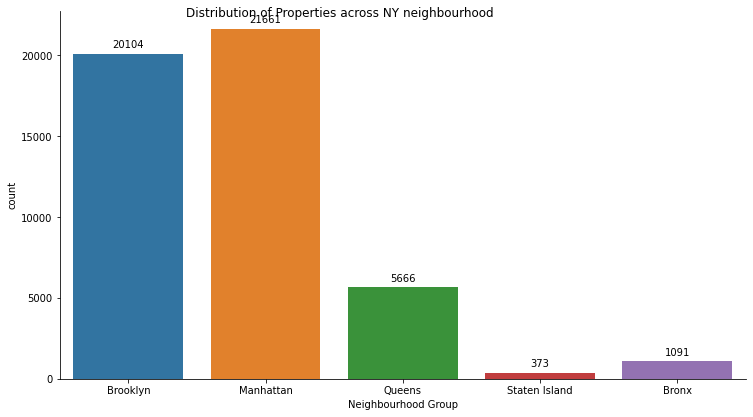

In [ ]:
plot = sns.catplot(x='neighbourhood_group', kind='count' ,data=df_in)
plot.fig.suptitle('Distribution of Properties across NY neighbourhood')
plot.set(xlabel = 'Neighbourhood Group')

ax = plot.facet_axis(0,0)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')


plot.fig.set_size_inches(12,6)

plt.show()

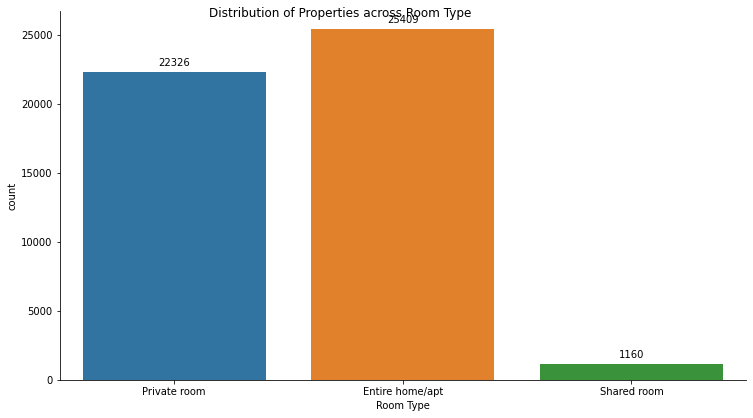

In [ ]:
plot = sns.catplot(x='room_type', kind='count' ,data=df_in)
plot.fig.suptitle('Distribution of Properties across Room Type')
plot.set(xlabel = 'Room Type')

ax = plot.facet_axis(0,0)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')


plot.fig.set_size_inches(12,6)

plt.show()

#Numerical Variables' Distribution

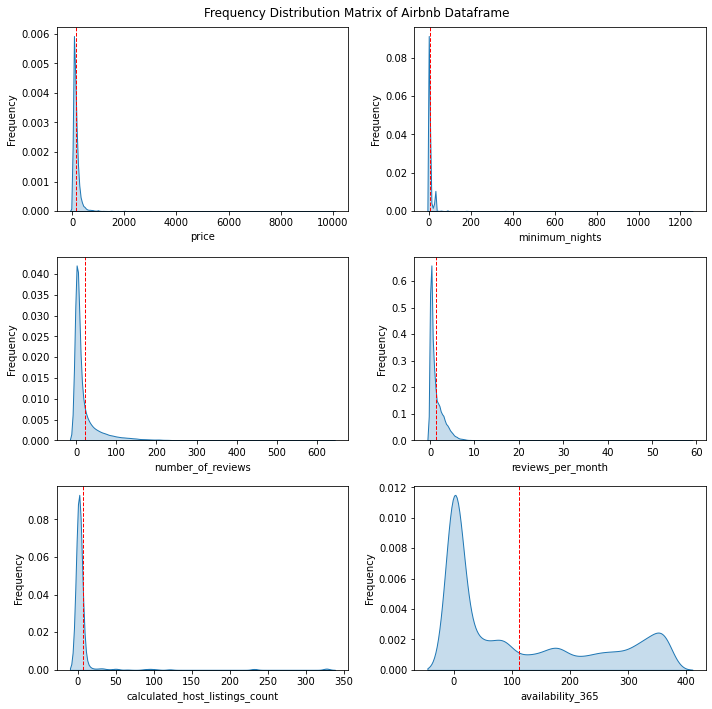

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

cols = ['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']

for idx, col in enumerate(cols):
    row = idx // 2
    col1 = idx % 2
    sns.kdeplot(ax=axs[row, col1], data=df_in, x=col, shade=True)
    axs[row, col1].set_xlabel(col)
    axs[row, col1].set_ylabel('Frequency')
    
    axs[row, col1].axvline(x=df_in[col].mean(), color='red', linestyle='dashed', linewidth=1)
    
fig.suptitle('Frequency Distribution Matrix of Airbnb Dataframe')

plt.tight_layout()
plt.show()


In [ ]:
df_in[['price','minimum_nights','number_of_reviews','reviews_per_month','calculated_host_listings_count','availability_365']].describe()

price  minimum_nights  number_of_reviews  reviews_per_month  \
count  48895.000000    48895.000000       48895.000000       38843.000000   
mean     152.720687        7.029962          23.274466           1.373221   
std      240.154170       20.510550          44.550582           1.680442   
min        0.000000        1.000000           0.000000           0.010000   
25%       69.000000        1.000000           1.000000           0.190000   
50%      106.000000        3.000000           5.000000           0.720000   
75%      175.000000        5.000000          24.000000           2.020000   
max    10000.000000     1250.000000         629.000000          58.500000   

       calculated_host_listings_count  availability_365  
count                    48895.000000      48895.000000  
mean                         7.143982        112.781327  
std                         32.952519        131.622289  
min                          1.000000          0.000000  
25%                          1.000000          0.000000  
50%                          1.000000         45.000000  
75%                          2.000000        227.000000  
max                        327.000000        365.000000

In [ ]:
#only 11 rows with no price
(df_in.price == 0).astype(int).sum()

11

Text(0.5, 0.98, 'Frequency Distribution of transformation with sqrt and log1p functions on Price')

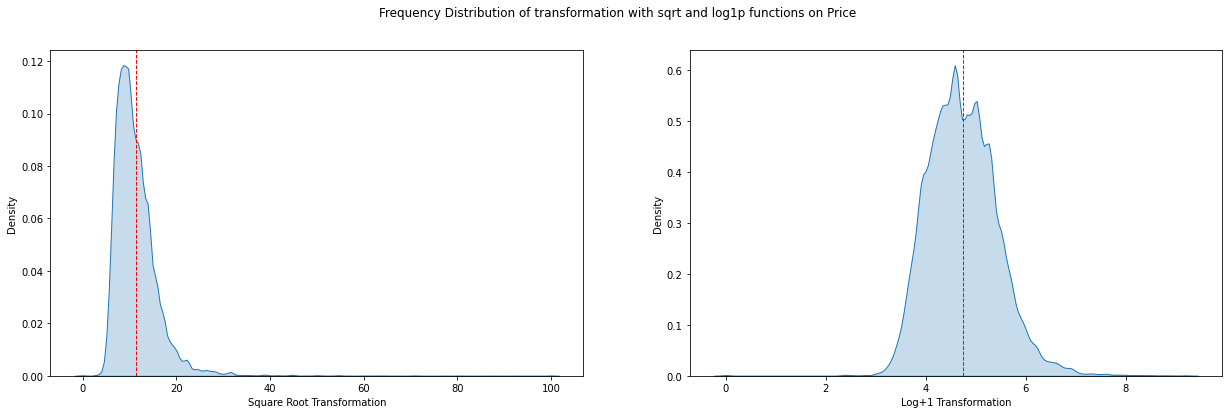

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(21,6))
sns.kdeplot(np.sqrt(df_in['price']), ax =axes[0], shade = 'True')
axes[0].axvline(x=(np.sqrt(df_in['price'])).mean(), color='red', linestyle='dashed', linewidth=1)
axes[0].set_xlabel('Square Root Transformation')

sns.kdeplot(np.log1p(df_in['price']), ax = axes[1], shade = 'True')
axes[1].axvline(x=(np.log1p(df_in['price'])).mean(), color='red', linestyle='dashed', linewidth=1)
axes[1].set_xlabel('Log+1 Transformation')

fig.suptitle('Frequency Distribution of transformation with sqrt and log1p functions on Price')

Text(0.5, 0.98, 'Frequency Distribution of transformation with log1p function on minimum_nights')

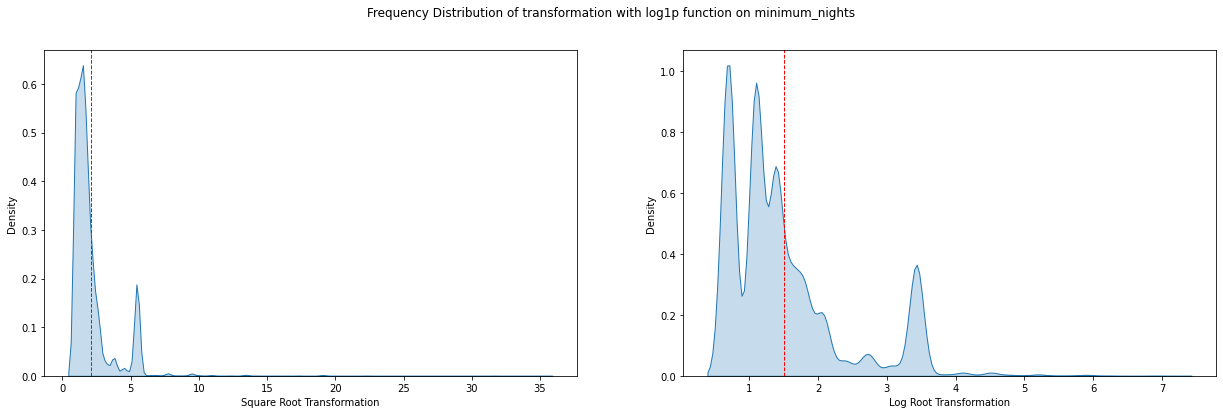

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(21,6))
sns.kdeplot(np.sqrt(df_in['minimum_nights']), ax =axes[0], shade = True)
axes[0].axvline(x=(np.sqrt(df_in['minimum_nights'])).mean(), color='red', linestyle='dashed', linewidth=1)
axes[0].set_xlabel('Square Root Transformation')

sns.kdeplot(np.log1p(df_in['minimum_nights']), ax = axes[1], shade = True)
axes[1].axvline(x=(np.log1p(df_in['minimum_nights'])).mean(), color='red', linestyle='dashed', linewidth=1)
axes[1].set_xlabel('Log Root Transformation')

fig.suptitle('Frequency Distribution of transformation with log1p function on minimum_nights')

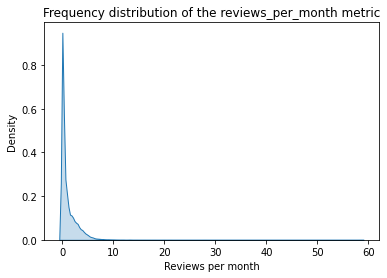

In [ ]:

plot = sns.kdeplot((df_in['reviews_per_month']), shade = True)

plot.set(title = 'Frequency distribution of the reviews_per_month metric')

plot.set(xlabel = 'Reviews per month')

plt.show()

In [ ]:
df_in['reviews_per_month'] = df_in['reviews_per_month'].fillna(0)

In [ ]:
df_in['last_review'] = pd.to_datetime(df_in['last_review'])

In [ ]:
old = min(df_in['last_review'])
df_in['last_review'] = df_in['last_review'].fillna(old)
df_in['days_since_review'] = df_in['last_review'].apply(lambda x: x.toordinal() - old.toordinal())

In [ ]:
df_in.price.describe()

count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

In [ ]:
df_in.minimum_nights.describe()

count    48895.000000
mean         7.029962
std         20.510550
min          1.000000
25%          1.000000
50%          3.000000
75%          5.000000
max       1250.000000
Name: minimum_nights, dtype: float64

In [ ]:
df_in['price'] = np.log1p(df_in['price'])

In [ ]:
df_in['minimum_nights_log'] = np.log1p(df_in['minimum_nights'])

In [ ]:
df_in.reviews_per_month.describe()

count    48895.000000
mean         1.090910
std          1.597283
min          0.000000
25%          0.040000
50%          0.370000
75%          1.580000
max         58.500000
Name: reviews_per_month, dtype: float64

In [ ]:
df_in['reviews_per_month'] = df_in[df_in['reviews_per_month'] < 15]['reviews_per_month']

In [ ]:
df_in['year_avail'] = df_in['availability_365']>365

df_in['no_reviews'] = df_in['reviews_per_month']==0

In [ ]:
df_in.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'days_since_review', 'minimum_nights_log',
       'year_avail', 'no_reviews'],
      dtype='object')

In [ ]:
df_out = df_in.drop(columns=['name', 'host_name','last_review','minimum_nights'])

In [ ]:
df_out.columns

Index(['id', 'host_id', 'neighbourhood_group', 'neighbourhood', 'latitude',
       'longitude', 'room_type', 'price', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'days_since_review', 'minimum_nights_log',
       'year_avail', 'no_reviews'],
      dtype='object')

In [ ]:
df_out['reviews_per_month'] = df_out['reviews_per_month'].fillna(0)

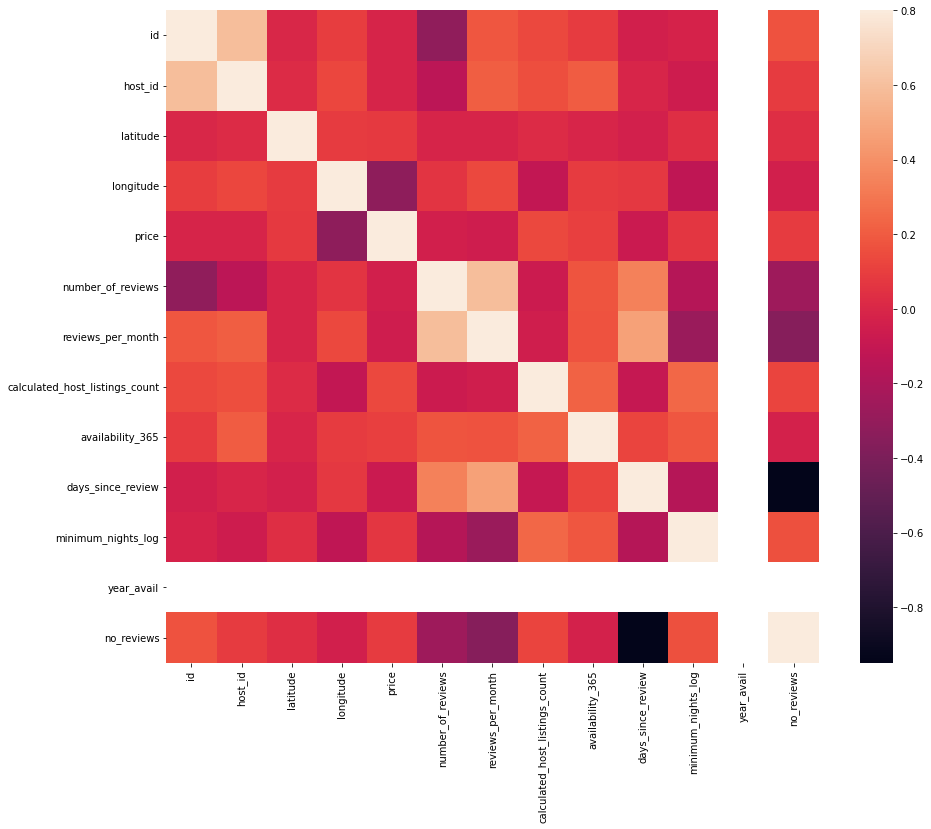

In [ ]:
corrmatrix = df_out.corr()
f, ax = plt.subplots(figsize=(15,12))
sns.heatmap(corrmatrix, vmax=0.8, square=True)
sns.set(font_scale=0.8)

In [ ]:
df_out.isnull().sum()

id                                0
host_id                           0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
days_since_review                 0
minimum_nights_log                0
year_avail                        0
no_reviews                        0
dtype: int64

#Feature Engineering

In [ ]:
categorical_features = df_out.select_dtypes(include=['object'])

In [ ]:
categorical_features_one_hot = pd.get_dummies(categorical_features)
categorical_features_one_hot.head()

neighbourhood_group_Bronx  neighbourhood_group_Brooklyn  \
0                          0                             1   
1                          0                             0   
2                          0                             0   
3                          0                             1   
4                          0                             0   

   neighbourhood_group_Manhattan  neighbourhood_group_Queens  \
0                              0                           0   
1                              1                           0   
2                              1                           0   
3                              0                           0   
4                              1                           0   

   neighbourhood_group_Staten Island  neighbourhood_Allerton  \
0                                  0                       0   
1                                  0                       0   
2                                  0                       0   
3                                  0                       0   
4                                  0                       0   

   neighbourhood_Arden Heights  neighbourhood_Arrochar  neighbourhood_Arverne  \
0                            0                       0                      0   
1                            0                       0                      0   
2                            0                       0                      0   
3                            0                       0                      0   
4                            0                       0                      0   

   neighbourhood_Astoria  ...  neighbourhood_Williamsburg  \
0                      0  ...                           0   
1                      0  ...                           0   
2                      0  ...                           0   
3                      0  ...                           0   
4                      0  ...                           0   

   neighbourhood_Willowbrook  neighbourhood_Windsor Terrace  \
0                          0                              0   
1                          0                              0   
2                          0                              0   
3                          0                              0   
4                          0                              0   

   neighbourhood_Woodhaven  neighbourhood_Woodlawn  neighbourhood_Woodrow  \
0                        0                       0                      0   
1                        0                       0                      0   
2                        0                       0                      0   
3                        0                       0                      0   
4                        0                       0                      0   

   neighbourhood_Woodside  room_type_Entire home/apt  room_type_Private room  \
0                       0                          0                       1   
1                       0                          1                       0   
2                       0                          0                       1   
3                       0                          1                       0   
4                       0                          1                       0   

   room_type_Shared room  
0                      0  
1                      0  
2                      0  
3                      0  
4                      0  

[5 rows x 229 columns]

In [ ]:
numerical_features =  df_out.select_dtypes(exclude=['object'])
price_value = numerical_features.price
numerical_features = numerical_features.drop(['price'], axis=1)
#print('Numerical features: {}'.format(numerical_features.shape))

In [ ]:
final_df = pd.concat([numerical_features, categorical_features_one_hot], axis=1)

In [ ]:
final_df.head(10)

id  host_id  latitude  longitude  minimum_nights  number_of_reviews  \
0  2539     2787  40.64749  -73.97237               1                  9   
1  2595     2845  40.75362  -73.98377               1                 45   
2  3647     4632  40.80902  -73.94190               3                  0   
3  3831     4869  40.68514  -73.95976               1                270   
4  5022     7192  40.79851  -73.94399              10                  9   
5  5099     7322  40.74767  -73.97500               3                 74   
6  5121     7356  40.68688  -73.95596              45                 49   
7  5178     8967  40.76489  -73.98493               2                430   
8  5203     7490  40.80178  -73.96723               2                118   
9  5238     7549  40.71344  -73.99037               1                160   

   reviews_per_month  calculated_host_listings_count  availability_365  \
0               0.21                               6               365   
1               0.38                               2               355   
2               0.00                               1               365   
3               4.64                               1               194   
4               0.10                               1                 0   
5               0.59                               1               129   
6               0.40                               1                 0   
7               3.47                               1               220   
8               0.99                               1                 0   
9               1.33                               4               188   

   days_since_review  ...  neighbourhood_Williamsburg  \
0               2762  ...                           0   
1               2976  ...                           0   
2                  0  ...                           0   
3               3021  ...                           0   
4               2793  ...                           0   
5               3008  ...                           0   
6               2383  ...                           0   
7               3010  ...                           0   
8               2307  ...                           0   
9               2995  ...                           0   

   neighbourhood_Willowbrook  neighbourhood_Windsor Terrace  \
0                          0                              0   
1                          0                              0   
2                          0                              0   
3                          0                              0   
4                          0                              0   
5                          0                              0   
6                          0                              0   
7                          0                              0   
8                          0                              0   
9                          0                              0   

   neighbourhood_Woodhaven  neighbourhood_Woodlawn  neighbourhood_Woodrow  \
0                        0                       0                      0   
1                        0                       0                      0   
2                        0                       0                      0   
3                        0                       0                      0   
4                        0                       0                      0   
5                        0                       0                      0   
6                        0                       0                      0   
7                        0                       0                      0   
8                        0                       0                      0   
9                        0                       0                      0   

   neighbourhood_Woodside  room_type_Entire home/apt  room_type_Private room  \
0                       0                          0                       1   
1                      

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(final_df, price_value, test_size=0.2, random_state=42)

In [ ]:
print('Dimensions of the training feature matrix: {}'.format(X_train.shape))
print('Dimensions of the training target vector: {}'.format(y_train.shape))
print('Dimensions of the test feature matrix: {}'.format(X_test.shape))
print('Dimensions of the test target vector: {}'.format(y_test.shape))

Dimensions of the training feature matrix: (39116, 241)
Dimensions of the training target vector: (39116,)
Dimensions of the test feature matrix: (9779, 241)
Dimensions of the test target vector: (9779,)


#Model Implementation

##catboost preprocessing steps

In [ ]:
df_x = df_out.drop(columns=['price'], axis = 1)

In [ ]:
df_y = df_out['price']

In [ ]:
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(df_x, df_y, test_size=0.2, random_state=42)

In [ ]:
train_pool = Pool(X_train_cat, y_train_cat, cat_features = ['neighbourhood_group', 'neighbourhood','room_type'])
test_pool = Pool(X_test_cat, y_test_cat, cat_features = ['neighbourhood_group', 'neighbourhood','room_type'])

###skip directly to use the model saved in Drive

In [ ]:
def CatBoost(LR = 0.01, itr = 1000, dep = 5, l2_val = 0.1, subs = 1, bt = 0.1):
   
    cb_model = CatBoostRegressor(learning_rate=LR,
                                 iterations=itr,
                                 depth =dep,
                                 l2_leaf_reg=l2_val,
                                 subsample=subs,
                                 bagging_temperature = bt,
                                 random_state=42,
                                 loss_function= 'RMSE')

    cb_model.fit(train_pool, verbose=False)
    y_pred = cb_model.predict(test_pool)

    print('r2 score: ' + str(r2_score(y_test, y_pred)))
    print('rmse (units): ' + str(mean_squared_error(np.expm1(y_test), np.expm1(y_pred), squared=False)) + '\n')

In [ ]:
def CatBoost_tuning (LR = 0.1, itr = 1000, dep = 5, l2_val = 0.1, subs = 1, bt = 0.1, 
                     param_test = {'learning_rate':[i/100.0 for i in range(5,20,2)]} ):
    
    gsearch = GridSearchCV(estimator = CatBoostRegressor(learning_rate=LR,
                                                         iterations=itr,
                                                         depth =dep,
                                                         l2_leaf_reg=l2_val,
                                                         subsample=subs,
                                                         bagging_temperature = bt,
                                                         random_state=42,
                                                         loss_function= 'RMSE'), 
                            param_grid = param_test, 
                            scoring='neg_mean_squared_error',
                            n_jobs=4, 
                            cv=3)

    gsearch.fit(X_train, y_train, verbose = False)
    return gsearch


In [ ]:
LearningRate = 0.1
iterations = 1000

In [ ]:
#baseline Catboost
CatBoost(LR = LearningRate, itr = iterations)

r2 score: 0.6381536705935184
rmse (units): 181.11701131932242



In [ ]:
# STEP 2 - Tuning Depth

parameters_test = {
    'depth':[3,5,7,9]
}

gsearch2_cb = CatBoost_tuning (LR = LearningRate, itr = iterations, param_test=parameters_test)
best_depth = gsearch2_cb.best_params_['depth']
print(f"{gsearch2_cb.best_params_} Best Score: {gsearch2_cb.best_score_}")

# Evaluation
CatBoost(LR = LearningRate, itr = iterations, dep = best_depth)

{'depth': 7} Best Score: -0.18826006063105785
r2 score: 0.6431288227399761
rmse (units): 179.36732661474687



In [ ]:
# STEP 3 - Tuning L2 Regularization

parameters_test = {
    'l2_leaf_reg': [0.01, 0.1, 0.5, 1, 2, 5]
}

gsearch3_cb = CatBoost_tuning (LR = LearningRate, itr = iterations, param_test=parameters_test)
best_l2 = gsearch3_cb.best_params_['l2_leaf_reg']
print(f"{gsearch3_cb.best_params_} Best Score: {gsearch3_cb.best_score_}")

# Evaluation
CatBoost(LR = LearningRate, itr = iterations, dep = best_depth, l2_val = best_l2)

{'l2_leaf_reg': 2} Best Score: -0.1890203053837631
r2 score: 0.6433264383389801
rmse (units): 180.4910180066357



In [ ]:
# STEP 4 - Tuning subsamples

parameters_test = {
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1]
}

gsearch4_cb = CatBoost_tuning (LR = LearningRate, itr = iterations, param_test=parameters_test)
best_sub = gsearch4_cb.best_params_['subsample']
print(f"{gsearch4_cb.best_params_} Best Score: {gsearch4_cb.best_score_}")

# Evaluation
CatBoost(LR = LearningRate, itr = iterations, dep = best_depth, l2_val = best_l2, subs = best_sub)

{'subsample': 0.8} Best Score: -0.1899458633050087
r2 score: 0.6442433317289746
rmse (units): 182.73123950273987



In [ ]:
# STEP 5 - Tuning BT

parameters_test = {
    'bagging_temperature': [0, 0.1, 0.5, 1, 2]
}

gsearch5_cb = CatBoost_tuning (LR = LearningRate, itr = iterations, param_test=parameters_test)
best_bt = gsearch5_cb.best_params_['bagging_temperature']
print(f"{gsearch5_cb.best_params_} Best Score: {gsearch5_cb.best_score_}")

# Evaluation
CatBoost(LR = LearningRate, itr = iterations, dep = best_depth, l2_val = best_l2, subs = best_sub, bt = best_bt)

{'bagging_temperature': 0} Best Score: -0.19049072659340863
r2 score: 0.6442433317289746
rmse (units): 182.73123950273987



In [ ]:
# STEP 6 - Tuning iterations

parameters_test = {
    'iterations': [500, 1000, 1500, 2000]
}

gsearch6_cb = CatBoost_tuning (LR = LearningRate, param_test=parameters_test)
best_itr = gsearch6_cb.best_params_['iterations']
print(f"{gsearch6_cb.best_params_} Best Score: {gsearch6_cb.best_score_}")

# Evaluation
CatBoost(LR = LearningRate, itr = best_itr, dep = best_depth, l2_val = best_l2, subs = best_sub, bt = best_bt)

{'iterations': 1500} Best Score: -0.19041914197830642
r2 score: 0.6449879799195477
rmse (units): 181.94821195561406



In [ ]:
# STEP 7 - Tuning LR

parameters_test = {
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.15, 0.2]
}

gsearch7_cb = CatBoost_tuning (LR = LearningRate, param_test=parameters_test)
best_lr = gsearch7_cb.best_params_['learning_rate']
print(f"{gsearch7_cb.best_params_} Best Score: {gsearch7_cb.best_score_}")

# Evaluation
CatBoost(LR = best_lr, itr = best_itr, dep = best_depth, l2_val = best_l2, subs = best_sub, bt = best_bt)

{'learning_rate': 0.1} Best Score: -0.19049072659340863
r2 score: 0.6449879799195477
rmse (units): 181.94821195561406



###best Catboost based on the parameters obtained

In [ ]:
best_cb_model = CatBoostRegressor(learning_rate=0.1,
                              iterations= 1500,
                              depth =7,
                              l2_leaf_reg=2,
                              subsample=0.8,
                              bagging_temperature = 0,
                              random_state=42,
                              loss_function= 'RMSE')

best_cb_model.fit(train_pool, verbose=False)

save_loc = '/content/drive/MyDrive/Ensemble_Project/catboostmodel_bestparams_20230317.cbm'

best_cb_model.save_model(save_loc)

###run this step to use pretrained Catboost model

In [ ]:
save_loc = '/content/drive/MyDrive/Ensemble_Project/catboostmodel_bestparams_20230317.cbm'

In [ ]:
loaded_model_cb = CatBoostRegressor()

loaded_model_cb.load_model(save_loc)

y_pred = loaded_model_cb.predict(test_pool)

print('r2 score: ' + str(r2_score(y_test, y_pred)))
print('rmse (units): ' + str(mean_squared_error(np.expm1(y_test), np.expm1(y_pred), squared=False)) + '\n')

r2 score: 0.6449879799195477
rmse (units): 181.94821195561406



#XGBoost Regressor 

##skip directly to run the XGBoost model saved in Drive

In [ ]:
def XGBoost(LR = 0.01, n_estimators = 100, max_depth = 5, reg_alpha = 0, subsample = 1):
   
    xgb_model = XGBRegressor(learning_rate=LR,
                             n_estimators=n_estimators,
                             max_depth=max_depth,
                             reg_alpha=reg_alpha,
                             subsample=subsample,
                             random_state=42,
                             objective= 'reg:squarederror')

    xgb_model.fit(X_train, y_train, verbose=False)
    y_pred = xgb_model.predict(X_test)

    print('r2 score: ' + str(r2_score(y_test, y_pred)))
    print('rmse (units): ' + str(mean_squared_error(np.expm1(y_test), np.expm1(y_pred), squared=False)) + '\n')


In [ ]:
def XGBoost_tuning(LR = 0.1, n_estimators = 100, max_depth = 5, reg_alpha = 0, subsample = 1, 
                   param_test = {'learning_rate':[i/100.0 for i in range(5,20,2)]}):
    
    xgb_model = XGBRegressor(learning_rate=LR,
                             n_estimators=n_estimators,
                             max_depth=max_depth,
                             reg_alpha=reg_alpha,
                             subsample=subsample,
                             random_state=42,
                             objective= 'reg:squarederror')

    gsearch = GridSearchCV(estimator=xgb_model, 
                           param_grid=param_test, 
                           scoring='neg_mean_squared_error',
                           n_jobs=4, 
                           cv=3)

    gsearch.fit(X_train, y_train, verbose = False)
    return gsearch

In [ ]:
LearningRate = 0.1
iterations = 1000

In [ ]:
#baseline XGboostregressor
XGBoost(LR = LearningRate, n_estimators = iterations)

r2 score: 0.6312345539596449
rmse (units): 181.6322469155302



In [ ]:
# STEP 2 - Tuning LR

parameters_test = {
    'learning_rate': [0.001, 0.01, 0.1]
} 

gsearch2_xg = XGBoost_tuning (n_estimators = iterations, param_test=parameters_test)
best_lr = gsearch2_xg.best_params_['learning_rate']
print(f"{gsearch2_xg.best_params_} Best Score: {gsearch2_xg.best_score_}")

# Evaluation
XGBoost(LR = best_lr, n_estimators = iterations)

{'learning_rate': 0.1} Best Score: -0.19161392885108422
r2 score: 0.6312345539596449
rmse (units): 181.6322469155302



In [ ]:
# STEP 3 - Tuning number of estimators

parameters_test = {
    'n_estimators': [100, 500, 1000]
} 

gsearch3_xg = XGBoost_tuning (LR = best_lr, param_test=parameters_test)
best_est = gsearch3_xg.best_params_['n_estimators']
print(f"{gsearch3_xg.best_params_} Best Score: {gsearch3_xg.best_score_}")

# Evaluation
XGBoost(LR = best_lr, n_estimators = best_est)

{'n_estimators': 500} Best Score: -0.19121141978804604


In [ ]:
best_lr  = 0.1
best_est = 500

In [ ]:
# STEP 4 - Tuning Max_Depth

parameters_test = {
    'max_depth': [3, 5, 7]
} 

gsearch4_xg = XGBoost_tuning (LR = best_lr, n_estimators = best_est, param_test=parameters_test)
best_depth = gsearch4_xg.best_params_['max_depth']
print(f"{gsearch4_xg.best_params_} Best Score: {gsearch4_xg.best_score_}")

# Evaluation
XGBoost(LR = best_lr, n_estimators = best_est, max_depth = best_depth)

{'max_depth': 7} Best Score: -0.19014960724520244
r2 score: 0.6376699487427047
rmse (units): 180.59877263181784



In [ ]:
# STEP 5 - Tuning subsample

parameters_test = {
    'subsample': [0.5, 0.75, 1]
} 

gsearch5_xg = XGBoost_tuning (LR = best_lr, n_estimators = best_est, param_test=parameters_test)
best_sub = gsearch5_xg.best_params_['subsample']
print(f"{gsearch5_xg.best_params_} Best Score: {gsearch5_xg.best_score_}")

# Evaluation
XGBoost(LR = best_lr, n_estimators = best_est, max_depth = best_depth, subsample = best_sub)

{'subsample': 0.75} Best Score: -0.19032707780722533
r2 score: 0.6401128024473707
rmse (units): 181.04760771604407



In [ ]:
# STEP 6 - Tuning reg alpha

parameters_test = {
    'reg_alpha': [0, 0.1, 0.5]
} 

gsearch6_xg = XGBoost_tuning (LR = best_lr, n_estimators = best_est, param_test=parameters_test)
best_alpha = gsearch6_xg.best_params_['reg_alpha']
print(f"{gsearch6_xg.best_params_} Best Score: {gsearch6_xg.best_score_}")

# Evaluation
XGBoost(LR = best_lr, n_estimators = best_est, max_depth = best_depth, subsample = best_sub, reg_alpha = best_alpha)

{'reg_alpha': 0.5} Best Score: -0.1897969373671422
r2 score: 0.6396263493413368
rmse (units): 182.06011093321067



In [ ]:
xgb_model_best = XGBRegressor(learning_rate=0.1,
                          n_estimators=500,
                          max_depth=7,
                          reg_alpha=0.5,
                          subsample=0.75,
                          random_state=42,
                          objective= 'reg:squarederror')

xgb_model_best.fit(X_train, y_train, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [ ]:
with open(save_loc, 'wb') as file:
    pickle.dump(xgb_model_best, file)

##run this step to use model from Drive

In [ ]:
save_loc = '/content/drive/MyDrive/Ensemble_Project/xgboostmodel_bestparameters_20230317.pkl'

In [ ]:
with open(save_loc, 'rb') as file:
    loaded_model_xgb = pickle.load(file)

In [ ]:
y_pred = loaded_model_xgb.predict(X_test)

print('r2 score: ' + str(r2_score(y_test, y_pred)))
print('rmse (units): ' + str(mean_squared_error(np.expm1(y_test), np.expm1(y_pred), squared=False)) + '\n')

r2 score: 0.6396263493413368
rmse (units): 182.06011093321067



#RandomForestRegressor Model

##Skip directly to run the model from Drive location

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV

In [ ]:
def RandomForest(n_estimators = 100, max_depth = 5, max_features = 'sqrt', min_samples_split = 2, min_samples_leaf = 1,
                 max_leaf_nodes = None,bootstrap = True,oob_score = True):
    
    rf_model = RandomForestRegressor(n_estimators=n_estimators,
                                      max_depth=max_depth,
                                      max_features=max_features,
                                     min_samples_split = min_samples_split,
                                     min_samples_leaf = min_samples_leaf,
                                     max_leaf_nodes = max_leaf_nodes,
                                     bootstrap = bootstrap,
                                     oob_score = oob_score,                                     
                                      random_state=42)

    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)

    print('r2 score: ' + str(r2_score(y_test, y_pred)))
    print('rmse (units): ' + str(mean_squared_error(np.expm1(y_test), np.expm1(y_pred), squared=False)) + '\n')

In [ ]:
  
def RandomForest_tuning(n_estimators = 100, max_depth = 5, max_features = 'sqrt', min_samples_split = 2, min_samples_leaf = 1,
                        max_leaf_nodes = None,bootstrap = True,oob_score = True,
                        param_test={'n_estimators': [50, 100, 150, 200]}):
    
    rf_model = RandomForestRegressor(n_estimators=n_estimators,
                                      max_depth=max_depth,
                                      max_features=max_features,
                                     min_samples_split = min_samples_split,
                                     min_samples_leaf = min_samples_leaf,
                                     max_leaf_nodes = max_leaf_nodes,
                                     bootstrap = bootstrap,
                                     oob_score = oob_score,                                     
                                      random_state=42)
    
    gsearch = GridSearchCV(estimator=rf_model, 
                           param_grid=param_test, 
                           scoring='neg_mean_squared_error',
                           n_jobs=4, 
                           cv=3)

    gsearch.fit(X_train, y_train)
    return gsearch


In [ ]:
#Baseline RandomForestRegressor

RandomForest()

r2 score: 0.38946795223440234
rmse (units): 204.01518863087483



In [ ]:
#Step 1 Tuning n_estimators parameters
parameters_test = {
    'n_estimators': [500, 1000, 1500, 2000]
} 

gsearch1_rf = RandomForest_tuning(param_test=parameters_test)
best_n_est = gsearch1_rf.best_params_['n_estimators']
print(f"{gsearch1_rf.best_params_} Best Score: {gsearch1_rf.best_score_}")

# Evaluation
RandomForest(n_estimators = best_n_est)


{'n_estimators': 500} Best Score: -0.29295852288579327
r2 score: 0.4037170065171939
rmse (units): 203.73956621253498



In [ ]:
best_n_est = 1500

In [ ]:
#Step 2 Tuning max_depth parameters
parameters_test = {
    'max_depth': [3,5,7, 10]
} 

gsearch2_rf = RandomForest_tuning(n_estimators = 1500,param_test=parameters_test)
best_depth = gsearch2_rf.best_params_['max_depth']
print(f"{gsearch2_rf.best_params_} Best Score: {gsearch2_rf.best_score_}")

# Evaluation
RandomForest(n_estimators = best_n_est, max_depth = best_depth)

{'max_depth': 10} Best Score: -0.2368273673868511
r2 score: 0.5276688202765514
rmse (units): 198.77810289351459



In [ ]:
#Step 3 Tuning max_features parameters
parameters_test = {
    'max_features': ['sqrt', 'log2']
} 

gsearch3_rf = RandomForest_tuning(n_estimators = 1500,param_test=parameters_test)
best_features = gsearch3_rf.best_params_['max_features']
print(f"{gsearch3_rf.best_params_} Best Score: {gsearch3_rf.best_score_}")

# Evaluation
RandomForest(n_estimators = best_n_est, max_depth = best_depth, max_features = best_features)

{'max_features': 'sqrt'} Best Score: -0.2926804728306393
r2 score: 0.5055095828059684
rmse (units): 199.76833894099718



In [ ]:
#Step 4 Tuning min_samples_split parameters
parameters_test = {
    'min_samples_split': [2, 5, 10]
} 

gsearch4_rf = RandomForest_tuning(n_estimators = 1500,param_test=parameters_test)
best_min_split = gsearch4_rf.best_params_['min_samples_split']
print(f"{gsearch4_rf.best_params_} Best Score: {gsearch4_rf.best_score_}")

# Evaluation
RandomForest(n_estimators = best_n_est, max_depth = best_depth, max_features = best_features, min_samples_split = best_min_split)

{'min_samples_split': 5} Best Score: -0.2913715230603582
r2 score: 0.5090099982284558
rmse (units): 199.57790024715158



In [ ]:
#Step 5 Tuning min_samples_leaf parameters
parameters_test = {
    'min_samples_leaf': [1, 2, 4]
} 

gsearch5_rf = RandomForest_tuning(n_estimators = 1500,param_test=parameters_test)
best_min_leaf = gsearch5_rf.best_params_['min_samples_leaf']
print(f"{gsearch5_rf.best_params_} Best Score: {gsearch5_rf.best_score_}")

# Evaluation
RandomForest(n_estimators = best_n_est, max_depth = best_depth, max_features = best_features, min_samples_split = best_min_split,
             min_samples_leaf = best_min_leaf)

{'min_samples_leaf': 2} Best Score: -0.29177905844455143
r2 score: 0.5106711417654367
rmse (units): 199.53165383040925



In [ ]:
#Step 6 Tuning max_leaf_nodes parameters
parameters_test = {
    'max_leaf_nodes': [None, 5, 10]
} 

gsearch6_rf = RandomForest_tuning(n_estimators = 1500,param_test=parameters_test)
best_max_leaf = gsearch6_rf.best_params_['max_leaf_nodes']
print(f"{gsearch6_rf.best_params_} Best Score: {gsearch6_rf.best_score_}")

# Evaluation
RandomForest(n_estimators = best_n_est, max_depth = best_depth, max_features = best_features, min_samples_split = best_min_split,
             min_samples_leaf = best_min_leaf, max_leaf_nodes = best_max_leaf)

{'max_leaf_nodes': None} Best Score: -0.2926804728306393
r2 score: 0.5106711417654367
rmse (units): 199.53165383040925



In [ ]:
#Step 8 Tuning oob parameters
parameters_test = {
    'oob_score': [True, False]
} 

gsearch8_rf = RandomForest_tuning(n_estimators = 1500,param_test=parameters_test)
best_oob = gsearch8_rf.best_params_['oob_score']
print(f"{gsearch8_rf.best_params_} Best Score: {gsearch8_rf.best_score_}")

# Evaluation
RandomForest(n_estimators = best_n_est, max_depth = best_depth, max_features = best_features, min_samples_split = best_min_split,
             min_samples_leaf = best_min_leaf, max_leaf_nodes = best_max_leaf, bootstrap = True, oob_score = best_oob)

{'oob_score': True} Best Score: -0.2926804728306393
r2 score: 0.5106711417654367
rmse (units): 199.53165383040925



In [ ]:
rf_model_best = RandomForestRegressor(n_estimators=1500,
                                  max_depth=30,
                                  max_features='sqrt',
                                  min_samples_split = 5,
                                  min_samples_leaf = 1,
                                  max_leaf_nodes = None,
                                  bootstrap = True,
                                  oob_score = False,                                     
                                  random_state=42)

rf_model_best.fit(X_train, y_train)

RandomForestRegressor(max_depth=30, max_features='sqrt', min_samples_split=5,
                      n_estimators=1500, random_state=42)

In [ ]:
save_loc = '/content/drive/MyDrive/Ensemble_Project/rf_model_bestparams_20230318.joblib'

In [ ]:
# Save the trained model to a file
dump(rf_model_best, save_loc)

['/content/drive/MyDrive/Ensemble_Project/rf_model_bestparams_20230318.joblib']

##Run this step directly with the tuned hyperparameters

In [ ]:
save_loc = '/content/drive/MyDrive/Ensemble_Project/rf_model_bestparams_20230318.joblib'

In [ ]:
# Load the saved model from file
loaded_model_rf = load(save_loc)

In [ ]:
y_pred = loaded_model_rf.predict(X_test)

print('r2 score: ' + str(r2_score(y_test, y_pred)))
print('rmse (units): ' + str(mean_squared_error(np.expm1(y_test), np.expm1(y_pred), squared=False)) + '\n')

r2 score: 0.6282915904851702
rmse (units): 189.655751546895



#Catboost Feature Importance & SHAP Values

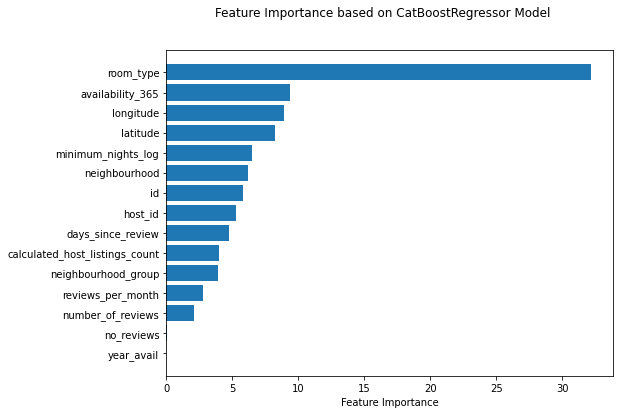

In [ ]:
# Calculate and plot the feature importance using the get_feature_importance method
feature_importances = loaded_model_cb.get_feature_importance()
feature_names = X_train_cat.columns.tolist()

feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=True)

fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(feature_importance_df['feature'], feature_importance_df['importance'])
ax.set_xlabel('Feature Importance')
fig.suptitle('Feature Importance based on CatBoostRegressor Model')
plt.show()

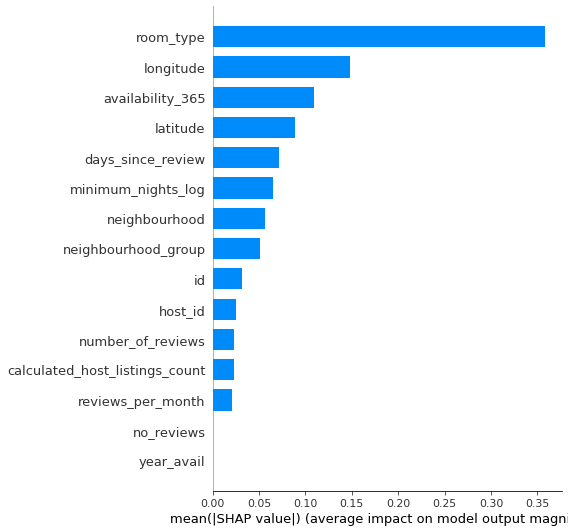

In [ ]:
# Calculate the SHAP values for each feature using the shap library
explainer = shap.Explainer(loaded_model_cb)
shap_values = explainer(X_train_cat)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_train_cat, plot_type="bar")
plt.show()

#XGBoostRegressor Feature Importance

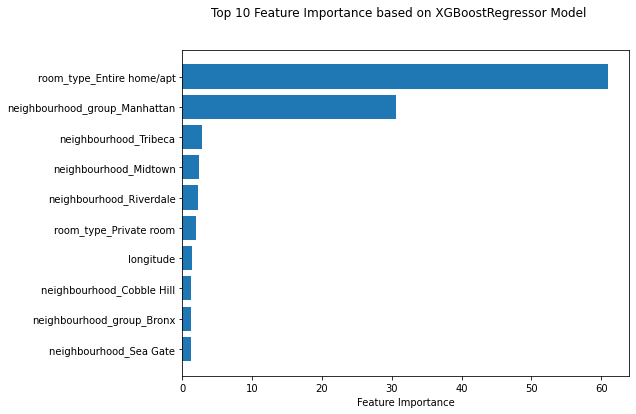

In [ ]:
# Calculate and plot the feature importance for XGBoostRegressor using the get_score method
importance_xgb = loaded_model_xgb.get_booster().get_score(importance_type='gain')
feature_names_xgb = X_train.columns.tolist()

feature_importance_df_xgb = pd.DataFrame({'feature': feature_names_xgb, 'importance': [importance_xgb.get(name, 0) for name in feature_names_xgb]})
top10 = feature_importance_df_xgb.nlargest(10, 'importance')
top10 = top10.iloc[::-1]

fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(top10['feature'], top10['importance'])
ax.set_xlabel('Feature Importance')
fig.suptitle('Top 10 Feature Importance based on XGBoostRegressor Model')
plt.show()

#RandomForestRegressor Feature Importance

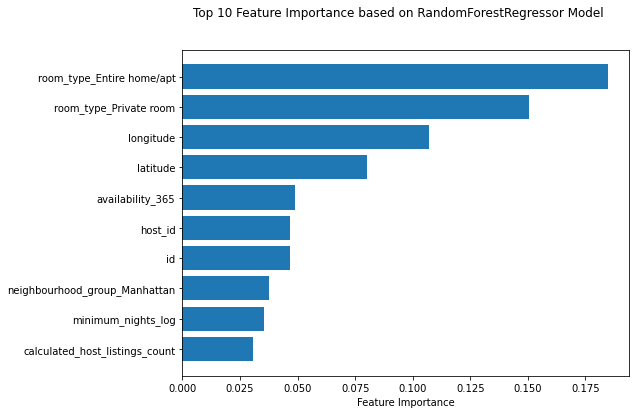

In [ ]:
# Calculate and plot the feature importance for RandomForestRegressor
importance_rf = loaded_model_rf.feature_importances_
feature_names_rf = X_train.columns.tolist()

feature_importance_df_rf = pd.DataFrame({'feature': feature_names_rf, 'importance': importance_rf})
top10 = feature_importance_df_rf.nlargest(10, 'importance')
top10 = top10.iloc[::-1]

fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(top10['feature'], top10['importance'])
ax.set_xlabel('Feature Importance')
fig.suptitle('Top 10 Feature Importance based on RandomForestRegressor Model')
plt.show()
